# Dependency

In [1]:
import h5py
import os

from tqdm import tqdm
from time import gmtime, strftime

import numpy as np
import math

from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import roc_curve

import tensorflow as tf
from tensorflow.keras import Model, layers

# Prams

In [2]:
NUM_DEPENDENT = 8

NUM_FILTER = 256
NUM_HIDDEN = 1000
BATCH_SIZE  = 1024
WINDOW_SIZES = [2,4,8]

NUM_CLASSES = 2
CLASS_NAMES = ['Negative','Positive']
MAXSEQ = NUM_DEPENDENT*2+1
NUM_FEATURE = 1024
EPOCHS      = 20

# File path

In [3]:

path_x_train = f"/htchang/DPCR/DataSet/Distance/ProtTrans/Train"
path_y_train = f"/htchang/DPCR/Data/FASTA/DNA_Train_573/label"

path_x_test = '/htchang/DPCR/DataSet/Distance/ProtTrans/Test129'
path_y_test = '/htchang/DPCR/Data/FASTA/DNA_Test_129/label'


# Time_log

In [4]:
def time_log(message):
    print(message," : ",strftime("%Y-%m-%d %H:%M:%S", gmtime()))

In [5]:
def MCNN_data_load(x_folder, y_folder):
    x_train = []
    y_train = []

    x_files = [file for file in os.listdir(x_folder) if file.endswith('.set.npy')]
    
    # Iterate through x_folder with tqdm
    for file in tqdm(x_files, desc="Loading data", unit="file"):
        x_path = os.path.join(x_folder, file)
        x_data = np.load(x_path)
        x_train.append(x_data)

        # Get the corresponding y file
        y_file = file[:-8] + '.label'
        y_path = os.path.join(y_folder, y_file)

        with open(y_path, 'r') as y_f:
            lines = y_f.readlines()
            y_data = np.array([int(x) for x in lines[1].strip()])
            y_train.append(y_data)

    # Concatenate all the data
    x_train = np.concatenate(x_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)

    # Add new dimensions to x_train and y_train
    x_train = np.expand_dims(x_train, axis=1)
    y_train = np.expand_dims(y_train, axis=1)
    y_train = tf.keras.utils.to_categorical(y_train,NUM_CLASSES)
    
    return x_train, y_train

# MCNN

In [6]:
class DeepScan(Model):

	def __init__(self,
	             input_shape=(1, MAXSEQ, NUM_FEATURE),
	             window_sizes=[1024],
	             num_filters=256,
	             num_hidden=1000):
		super(DeepScan, self).__init__()
		# Add input layer
		self.input_layer = tf.keras.Input(input_shape)
		self.window_sizes = window_sizes
		self.conv2d = []
		self.maxpool = []
		self.flatten = []
		for window_size in self.window_sizes:
			self.conv2d.append(
			 layers.Conv2D(filters=num_filters,
			               kernel_size=(1, window_size),
			               activation=tf.nn.relu,
			               padding='valid',
			               bias_initializer=tf.constant_initializer(0.1),
			               kernel_initializer=tf.keras.initializers.GlorotUniform()))
			self.maxpool.append(
			 layers.MaxPooling2D(pool_size=(1, MAXSEQ - window_size + 1),
			                     strides=(1, MAXSEQ),
			                     padding='valid'))
			self.flatten.append(layers.Flatten())
		self.dropout = layers.Dropout(rate=0.7)
		self.fc1 = layers.Dense(
		 num_hidden,
		 activation=tf.nn.relu,
		 bias_initializer=tf.constant_initializer(0.1),
		 kernel_initializer=tf.keras.initializers.GlorotUniform())
		self.fc2 = layers.Dense(NUM_CLASSES,
		                        activation='softmax',
		                        kernel_regularizer=tf.keras.regularizers.l2(1e-3))

		# Get output layer with `call` method
		self.out = self.call(self.input_layer)

	def call(self, x, training=False):
		_x = []
		for i in range(len(self.window_sizes)):
			x_conv = self.conv2d[i](x)
			x_maxp = self.maxpool[i](x_conv)
			x_flat = self.flatten[i](x_maxp)
			_x.append(x_flat)

		x = tf.concat(_x, 1)
		x = self.dropout(x, training=training)
		x = self.fc1(x)
		x = self.fc2(x)  #Best Threshold
		return x


def val_binary(epoch, logs):

	pred = model.predict(x_test)

	fpr, tpr, thresholds = roc_curve(y_test[:, 1], pred[:, 1])
	# calculate the g-mean for each threshold
	gmeans = np.sqrt(tpr * (1 - fpr))
	# locate the index of the largest g-mean
	ix = np.argmax(gmeans)
	print(f'Best Threshold={thresholds[ix]}, G-Mean={gmeans[ix]}')
	threshold = thresholds[ix]

	y_pred = (pred[:, 1] >= threshold).astype(int)

	fout = open(f'{LOG_DIR}/training.csv', 'a')

	TN, FP, FN, TP = metrics.confusion_matrix(y_test[:, 1], y_pred).ravel()

	Sens = TP / (TP + FN) if TP + FN > 0 else 0.0
	Spec = TN / (FP + TN) if FP + TN > 0 else 0.0
	Acc = (TP + TN) / (TP + FP + TN + FN)
	MCC = (TP * TN - FP * FN) / math.sqrt(
	 (TP + FP) * (TP + FN) * (TN + FP) *
	 (TN + FN)) if TP + FP > 0 and FP + TN > 0 and TP + FN and TN + FN else 0.0
	F1 = 2 * TP / (2 * TP + FP + FN)
	print(
	 f'{epoch + 1},TP={TP}, FP={FP}, TN={TN}, FN={FN}, Sens={Sens:.4f}, Spec={Spec:.4f}, Acc={Acc:.4f}, MCC={MCC:.4f}\n'
	)
	fout.write(
	 f'{epoch + 1},{TP},{FP},{TN},{FN},{Sens:.4f},{Spec:.4f},{Acc:.4f},{MCC:.4f}\n'
	)
	fout.close()


# Main

In [7]:
# Example usage:
x_train, y_train = MCNN_data_load(path_x_train, path_y_train)


Loading data: 100%|██████████| 569/569 [02:16<00:00,  4.18file/s]


In [8]:
x_test, y_test = MCNN_data_load(path_x_test, path_y_test)

Loading data: 100%|██████████| 129/129 [00:33<00:00,  3.86file/s]


In [9]:
print(x_train.shape)
print(y_train.shape)

(157831, 1, 17, 1024)
(157831, 2)


In [10]:
print(x_test.shape)
print(y_test.shape)

(37515, 1, 17, 1024)
(37515, 2)


In [11]:
# Model Train
time_log("Start Model Train")
model = DeepScan(
    num_filters=NUM_FILTER,
    num_hidden=NUM_HIDDEN,
    window_sizes=WINDOW_SIZES)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=x_train.shape)
model.summary()

model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=60,
    shuffle=True,
)
time_log("End Model Train")

Start Model Train  :  2023-04-23 17:07:09
Model: "deep_scan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 16, 256)        524544    
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 14, 256)        1048832   
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 10, 256)        2097408   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 256)        0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 256)        0         
 2D)                                                             
                                                                 
 max_pooling2d_

Start Model Test  :  2023-04-23 17:10:43
170/170 [==============================] - 0s 1ms/step
Best Threshold=0.00012759980745613575, G-Mean=0.835925082508382
TP=399, FP=941, TN=4034, FN=64, Sens=0.8618, Spec=0.8109, Acc=0.8152, MCC=0.4356

End Model Test  :  2023-04-23 17:10:44


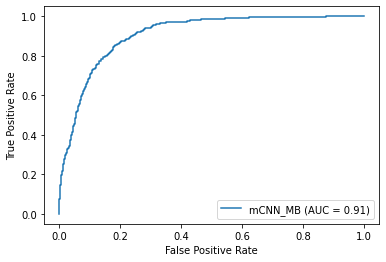

In [12]:
time_log("Start Model Test")

pred_test = model.predict(x_test[0:5438])
fpr, tpr, thresholds = roc_curve(y_test[0:5438][:,1], pred_test[:, 1])
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='mCNN_MB')
display.plot()

# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print(f'Best Threshold={thresholds[ix]}, G-Mean={gmeans[ix]}')
threshold = thresholds[ix]

y_pred = (pred_test[:, 1] >= threshold).astype(int)

TN, FP, FN, TP =  metrics.confusion_matrix(y_test[0:5438][:,1], y_pred).ravel()

Sens = TP/(TP+FN) if TP+FN > 0 else 0.0
Spec = TN/(FP+TN) if FP+TN > 0 else 0.0
Acc = (TP+TN)/(TP+FP+TN+FN)
MCC = (TP*TN-FP*FN)/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) if TP+FP > 0 and FP+TN > 0 and TP+FN and TN+FN else 0.0
F1 = 2*TP/(2*TP+FP+FN)
print(f'TP={TP}, FP={FP}, TN={TN}, FN={FN}, Sens={Sens:.4f}, Spec={Spec:.4f}, Acc={Acc:.4f}, MCC={MCC:.4f}\n')

time_log("End Model Test")